In [1]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
text = nlp('Hi, My name is Aman Kharwal \n I am from India \n I want to work with Google \n Steve Jobs is My Inspiration')
displacy.render(text, style = 'ent', jupyter=True)

In [2]:
import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.6.0


### Load and explore NER data set

In [3]:
import pandas as pd
df = pd.read_csv('ner_dataset.csv', encoding='latin1')
df = df.fillna(method='ffill')
df.head(20)

Sentence #           Word  POS    Tag
0   Sentence: 1      Thousands  NNS      O
1   Sentence: 1             of   IN      O
2   Sentence: 1  demonstrators  NNS      O
3   Sentence: 1           have  VBP      O
4   Sentence: 1        marched  VBN      O
5   Sentence: 1        through   IN      O
6   Sentence: 1         London  NNP  B-geo
7   Sentence: 1             to   TO      O
8   Sentence: 1        protest   VB      O
9   Sentence: 1            the   DT      O
10  Sentence: 1            war   NN      O
11  Sentence: 1             in   IN      O
12  Sentence: 1           Iraq  NNP  B-geo
13  Sentence: 1            and   CC      O
14  Sentence: 1         demand   VB      O
15  Sentence: 1            the   DT      O
16  Sentence: 1     withdrawal   NN      O
17  Sentence: 1             of   IN      O
18  Sentence: 1        British   JJ  B-gpe
19  Sentence: 1         troops  NNS      O

In [4]:
print('Unique words in corpus: ', df['Word'].nunique())
print('Unique tags in corpus: ', df['Tag'].nunique())

Unique words in corpus:  12682
Unique tags in corpus:  17


In [5]:
words = list(set(df['Word'].values))
words.append('ENDPAD')
num_words = len(words)

In [6]:
tags = list(set(df['Tag'].values))
num_tags = len(tags)

In [7]:
num_words, num_tags

(12683, 17)

### Retrieve sentences and corresponding tags

In [8]:
class SentenceGetter(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                          s['POS'].values.tolist(),
                                                          s['Tag'].values.tolist())]
        self.grouped = self.df.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [9]:
getter = SentenceGetter(df)
sentences = getter.sentences

In [10]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Define mappings between sentences and tags

In [11]:
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [12]:
word2idx

{'1,200': 1,
 'Cavaco': 2,
 'Chief': 3,
 '1981': 4,
 'Obama': 5,
 'replacing': 6,
 'Karachi': 7,
 'hours': 8,
 'buried': 9,
 'Afghan-based': 10,
 'Jamaican': 11,
 'tsunami': 12,
 'MS-13': 13,
 'combination': 14,
 'percentage': 15,
 'high-ranking': 16,
 'enable': 17,
 'Hispanic': 18,
 'harassed': 19,
 'Cyclone': 20,
 'socio-economic': 21,
 'heightened': 22,
 '600': 23,
 'Villaraigosa': 24,
 'feels': 25,
 '60,000': 26,
 '2,00,000': 27,
 'Musa': 28,
 'following': 29,
 'depletion': 30,
 'districts': 31,
 'mingled': 32,
 'Liuguantun': 33,
 'Gholamreza': 34,
 'adequate': 35,
 'sanction': 36,
 'provide': 37,
 'financing': 38,
 'Nikolai': 39,
 'wins': 40,
 'Movement': 41,
 '130': 42,
 'Sofia': 43,
 'topic': 44,
 'explosions': 45,
 'Egeland': 46,
 'terrorists': 47,
 'deadliest': 48,
 'Vasilily': 49,
 'intense': 50,
 'surrender': 51,
 'remains': 52,
 'earth': 53,
 'spends': 54,
 'bumper': 55,
 'Sivaram': 56,
 'comment': 57,
 'duress': 58,
 'downward': 59,
 'aside': 60,
 'Bryant': 61,
 'Unfortuna

In [13]:
tag2idx

{'O': 0,
 'B-art': 1,
 'I-art': 2,
 'I-gpe': 3,
 'I-tim': 4,
 'B-tim': 5,
 'I-eve': 6,
 'B-nat': 7,
 'I-org': 8,
 'B-geo': 9,
 'B-eve': 10,
 'B-gpe': 11,
 'I-per': 12,
 'I-nat': 13,
 'B-org': 14,
 'I-geo': 15,
 'B-per': 16}

### Padding input sentences and creating train/test split

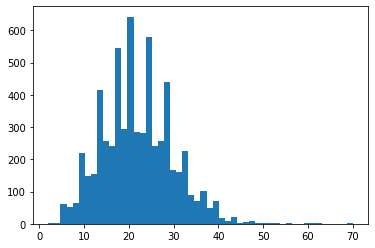

In [14]:
import matplotlib.pyplot as plt 
plt.hist([len(s) for s in sentences], bins=50)
plt.show();

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50
X = [[word2idx[w[0]] for w in s] for s in sentences]
X

[[11797,
  661,
  2938,
  1388,
  6234,
  1389,
  7488,
  3353,
  544,
  5123,
  5079,
  10453,
  6840,
  12383,
  941,
  5123,
  3066,
  661,
  3630,
  10790,
  3114,
  6897,
  2534,
  2926],
 [3875,
  2271,
  6340,
  5039,
  10535,
  3353,
  1498,
  10008,
  3353,
  11648,
  11726,
  11109,
  661,
  5123,
  8135,
  1376,
  9409,
  3210,
  2313,
  3084,
  3005,
  5521,
  7608,
  3672,
  2926],
 [825,
  4313,
  11845,
  2041,
  2732,
  2475,
  10453,
  5123,
  811,
  7316,
  3052,
  9409,
  3314,
  8359,
  8253,
  12027,
  11105,
  4353,
  3353,
  1388,
  378,
  3353,
  1718,
  2313,
  2459,
  9405,
  6225,
  10453,
  4281,
  6402,
  6971,
  2926],
 [3733, 8011, 3210, 12012, 6849, 8151, 4410, 5017, 8381, 7845, 2926],
 [2018, 12225, 9742, 11330, 7381, 8011, 6474, 10729, 6739, 10453, 1193, 2926],
 [790,
  3466,
  5903,
  1388,
  4005,
  9409,
  10558,
  7381,
  2553,
  9409,
  12383,
  5123,
  11696,
  661,
  5123,
  7864,
  7381,
  514,
  2926],
 [5769,
  11793,
  2597,
  7628,
  7381,


In [16]:
X = pad_sequences(maxlen = max_len, sequences = X, padding='post', value=num_words-1)
X

array([[11797,   661,  2938, ..., 12682, 12682, 12682],
       [ 3875,  2271,  6340, ..., 12682, 12682, 12682],
       [  825,  4313, 11845, ..., 12682, 12682, 12682],
       ...,
       [ 2018,  2318,  8170, ..., 12682, 12682, 12682],
       [11797,   661, 11178, ..., 12682, 12682, 12682],
       [ 5639,   661,  7491, ..., 12682, 12682, 12682]])

In [17]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y

[[0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0],
 [11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 14, 0, 0, 0, 0, 0],
 [0,
  0,
  5,
  0,
  0,
  0,
  0,
  0,
  9,
  0,
  0,
  0,
  0,
  0,
  14,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  9,
  15,
  0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 16, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 14, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 14, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 9, 0, 0],
 [0, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 11, 0, 0, 0, 0, 0, 9, 0, 0, 14, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0,

In [18]:
y = pad_sequences(maxlen = max_len, sequences = y, padding = 'post', value = tag2idx['O'])
y

array([[ 0,  0,  0, ...,  0,  0,  0],
       [11,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  5, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0, 11, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [19]:
y = [to_categorical(i, num_classes=num_tags) for i in y]
y

[array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

### Build and compile a Bidirectional LSTM model

In [21]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [22]:
input_word = Input(shape=(max_len, ))
model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            634150    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 758,367
Trainable params: 758,367
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the model

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [25]:
import numpy as np
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [early_stopping]

history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size = 32,
    epochs = 3,
    verbose = 1,
#    callbacks = callbacks
)

Epoch 1/3
140/140 [==============================] - 67s 428ms/step - loss: 0.5327 - accuracy: 0.9264 - val_loss: 0.3163 - val_accuracy: 0.9311
Epoch 2/3
140/140 [==============================] - 60s 429ms/step - loss: 0.2452 - accuracy: 0.9361 - val_loss: 0.2042 - val_accuracy: 0.9404
Epoch 3/3
140/140 [==============================] - 59s 418ms/step - loss: 0.1654 - accuracy: 0.9484 - val_loss: 0.1657 - val_accuracy: 0.9488


### Evaluate Named Entity Recognition model

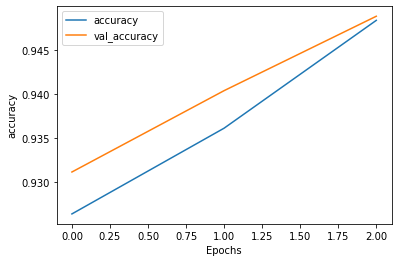

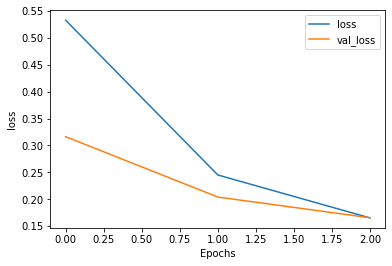

In [26]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss");

In [27]:
model.evaluate(x_test, np.array(y_test))

20/20 [==============================] - 1s 46ms/step - loss: 0.1658 - accuracy: 0.9504


[0.16577942669391632, 0.950354814529419]

In [31]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]

print('{:15}{:5}\t {}\n'.format('Word', 'True', 'Pred'))
print('-'*30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print('{:15}{}\t{}'.format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
Earlier        O	O
this           O	O
week           O	O
,              O	O
a              O	O
U.S.           B-geo	B-geo
military       O	O
judge          O	O
threw          O	O
out            O	O
the            O	O
guilty         O	O
plea           O	O
of             O	O
Army           B-org	B-geo
Private        I-org	O
First          I-org	O
Class          I-org	O
Lynndie        I-org	O
England        I-org	O
in             O	O
connection     O	O
with           O	O
the            O	O
scandal        O	O
.              O	O
professional   O	O
professional   O	O
professional   O	O
professional   O	O
professional   O	O
professional   O	O
professional   O	O
professional   O	O
professional   O	O
professional   O	O
professional   O	O
professional   O	O
professional   O	O
professional   O	O
professional   O	O
professional   O	O
professional   O	O
professional   O	O
professional   O	O
professional   O	O
professional   O	O
professional

In [ ]:
import pickle

# serialize model to JSON
model_json = model.to_json()
with open("ner_model.json", "w") as json_file:
    json_file.write(model_json)
    
# saving model
new_model.save('ner_model.h5')
print("Model saved")

# saving tokenizer
with open('ner_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print('Tokenizer saved')